In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import dual_annealing
from scipy.optimize import minimize
from scipy import optimize
from scipy.optimize import LinearConstraint, Bounds
#%config InlineBackend.figure_format = 'retina'

def carregar_dados():
    precos = pd.read_csv("../dados/cotacoes-2021-jan-ago.csv", index_col=0, parse_dates=True)
    cake = pd.read_csv("../dados/cake-2021-jan-ago.csv", index_col=0, parse_dates=True)
    precos['CAKE'] = cake['price']

    return precos

def imprimir_resultado(simbolos, pesos):
    pesos = pesos * 100
    for i in range(len(simbolos)):
        print(simbolos[i] + ": " + "%.2f" % pesos[i])

#  retorna array com retorno, volatilidade e sharpe ratio da carteira        
def calcular_desempenho(pesos):
    pesos = np.array(pesos)
    periodos = retornos_log.count()[0]
    ret = np.sum(retorno_medio_log * pesos) * periodos
    vol = np.sqrt(np.dot(pesos.T, np.dot(retorno_log_cov * periodos, pesos)))
    sr = ret / vol

#     retornos.append(ret)
#     volatilidades.append(vol)
#     sharpe_ratio.append(vol)

    return np.array([ret, vol, sr])

def neg_sharpe_ratio(pesos):
    return calcular_desempenho(pesos)[2] * -1     

def minimize_volatility(pesos):
    return calcular_desempenho(pesos)[1]

In [2]:
precos = carregar_dados()
precos

,BTC,ETH,BNB,ADA,LINK,LTC,XRP,SOL,DOT,BCH,CAKE
Date,,,,,,,,,,,
2021-01-01,29374.152344,730.367554,37.905010,0.175350,11.872555,126.230347,0.237444,1.842084,8.306819,341.985657,0.618341
2021-01-02,32127.267578,774.534973,38.241592,0.177423,12.220137,136.944885,0.221655,1.799275,9.208837,354.599945,0.656774
2021-01-03,32782.023438,975.507690,41.148979,0.204995,13.650172,160.190582,0.225848,2.161752,10.033283,421.789856,0.615835
2021-01-04,31971.914062,1040.233032,40.926353,0.224762,13.571063,154.807327,0.236677,2.485097,9.469611,407.936920,0.632956
2021-01-05,33992.429688,1100.006104,41.734600,0.258314,14.539868,158.594772,0.226750,2.157217,9.701656,419.768127,0.630313
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-11,44428.289062,3043.414307,385.818970,1.823878,24.917234,165.131027,0.964549,41.099361,20.754807,605.007507,18.915866
2021-08-12,47793.320312,3322.211670,410.944885,2.136079,27.733137,183.286087,1.089960,44.894501,22.714149,653.958496,19.715876
2021-08-13,47096.945312,3265.443359,409.034485,2.191687,27.155422,182.711273,1.280412,44.112850,22.861027,689.114868,19.421632


# Markowitz Efficient Frontier

In [3]:
retornos_log = np.log(precos/precos.shift(1))
retornos_log = retornos_log[1:]
retorno_medio_log = retornos_log.mean()
retorno_log_cov = retornos_log.cov()

In [4]:
simbolos = precos.columns.tolist()
bounds = [(0,1)] * len(simbolos)
initial_guess = [1 / len(simbolos)] * len(simbolos)
# # restrição para soma dos pesos ser igual a 1
# constraint = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# retornos = []
# volatilidades = []
sharpe_ratio = []

# resultado = optimize.minimize(neg_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraint, options={"disp":True})
# print(resultado)

In [5]:
frontier_y = np.linspace(1, 3.5, 100)
frontier_x = []

for possivel_retorno in frontier_y:
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type':'eq', 'fun': lambda w: calcular_desempenho(w)[0] - possivel_retorno})
    resultado = optimize.minimize(minimize_volatility, initial_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(resultado['fun'])
    sharpe_ratio.append( calcular_desempenho(resultado.x)[2] )

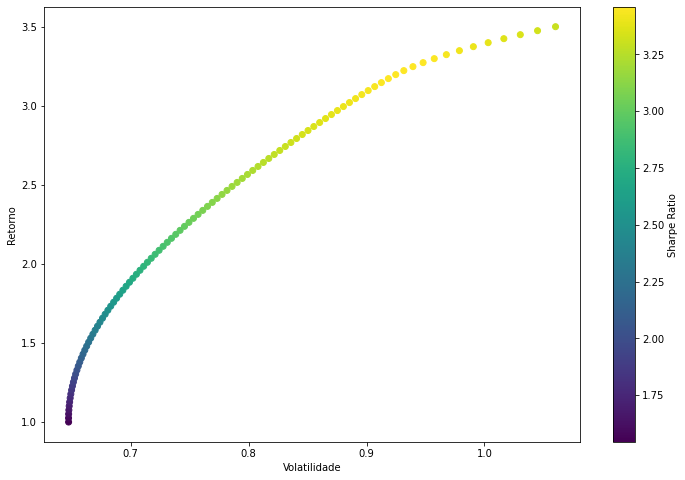

In [6]:
plt.figure(figsize=(12,8))
# plt.scatter(volatilidades, retornos, c=sharpe_ratio, cmap='viridis')
plt.scatter(frontier_x, frontier_y, c=sharpe_ratio, cmap='viridis')
# plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
# plt.scatter(max_sratio_vol, max_sratio_ret, c='red')#, s=50) # red dot
plt.show()

### Carteira com maior sharpe ratio

In [7]:
# max_sharpe_ratio = max(sharpe_ratio)
# max_sharpe_index = sharpe_ratio.index(max_sharpe_ratio)
# max_sratio_vol = volatilidades[max_sharpe_index]
# max_sratio_ret = retornos[max_sharpe_index]
# imprimir_resultado(simbolos, pesos_carteiras[max_sharpe_index])